[PINN] epoch    1  loss=2.0836e-01  resid=8.1022e-01  data=1.0298e+01  b_hat=0.7185
[PINN] epoch  200  loss=2.1406e-03  resid=1.7973e+00  data=2.6497e-02  b_hat=0.6260
[PINN] epoch  400  loss=1.7274e-01  resid=1.2865e-01  data=2.2997e-01  b_hat=0.5471
[PINN] epoch  600  loss=1.3596e-01  resid=9.8072e-02  data=2.0116e-01  b_hat=0.4329
[PINN] epoch  800  loss=9.1446e-02  resid=5.0048e-02  data=2.0529e-01  b_hat=0.3737
[PINN] epoch 1000  loss=6.7550e-02  resid=2.2738e-02  data=2.1022e-01  b_hat=0.3496
[PINN] epoch 1200  loss=6.3207e-02  resid=1.9221e-02  data=2.0512e-01  b_hat=0.3222
[PINN] epoch 1400  loss=6.0485e-02  resid=1.8420e-02  data=1.9720e-01  b_hat=0.2919
[PINN] epoch 1600  loss=5.7879e-02  resid=1.8032e-02  data=1.8770e-01  b_hat=0.2609
[PINN] epoch 1800  loss=5.4788e-02  resid=1.9684e-02  data=1.6904e-01  b_hat=0.2272
[PINN] epoch 2000  loss=1.8697e-02  resid=8.1620e-03  data=2.5401e-02  b_hat=0.1738
[PINN] epoch 2200  loss=1.3238e-02  resid=4.7074e-03  data=1.9294e-02  b_hat

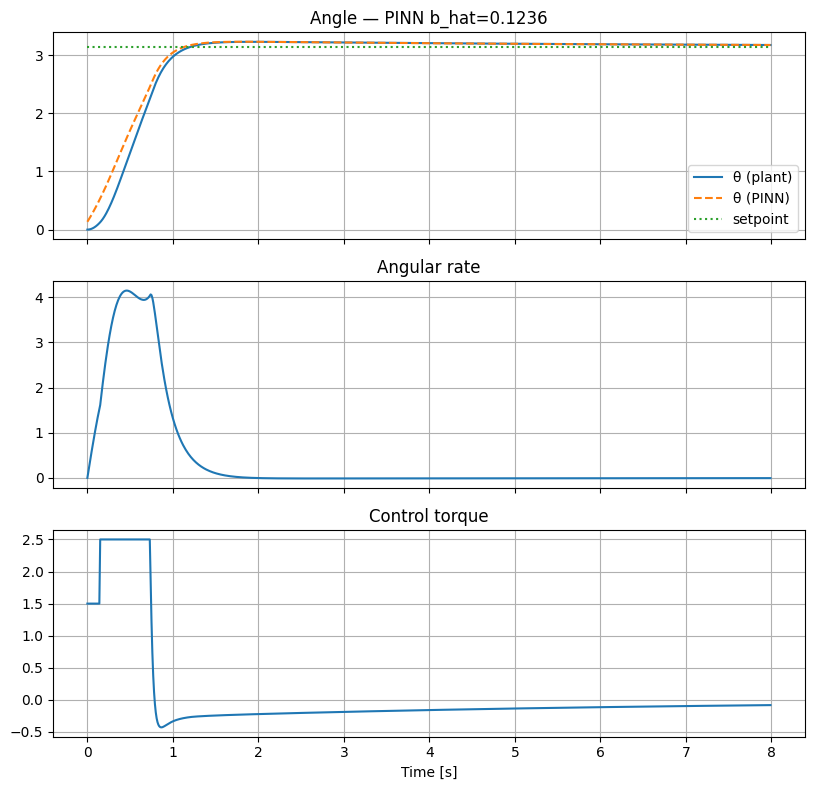

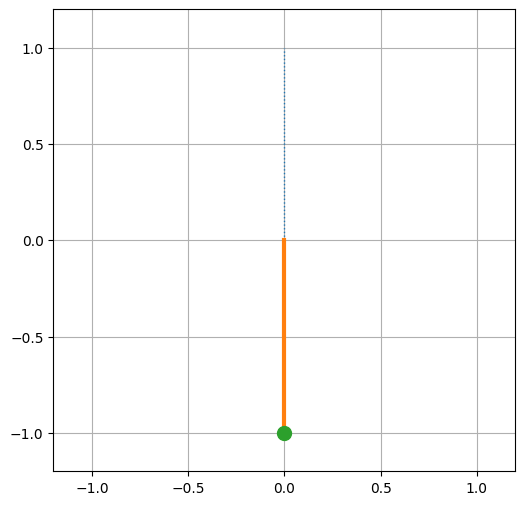

c:\Users\siona\miniconda3\envs\myenv\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [1]:
"""
Inverted Pendulum — Digital Twin (DT) Teaching Example
=====================================================

What you get in this single file
--------------------------------
1) **Nonlinear plant** (rotary inverted pendulum with direct torque at the pivot).
2) **PID controller** to swing-up and stabilize at the upright setpoint (θ* = π rad).
3) **Digital Twin runner** that logs telemetry and compares truth vs twin.
4) **PINN** (Physics-Informed Neural Network) that learns from telemetry by
   minimizing the ODE residual **and** a small amount of data-fit loss; the PINN
   estimates the damping b (and can be extended to estimate m if desired) and
   reconstructs θ(t) from time alone + known input u(t).
5) **Visualization**: time-series plots + a simple animation of the pendulum.

System model
------------
We use a simple rotary-pendulum model with a torque input u at the hinge:

    m l^2 θ¨ + b θ˙ + m g l sin(θ) = u

=>  θ¨ = [u - b θ˙ - m g l sin(θ)] / (m l^2)

State vector: x = [θ, θ̇]. Parameters: mass m, length l, viscous friction b, gravity g.
We treat the rod as massless with a point mass m at distance l; feel free to
swap in a more detailed inertia if teaching moment-of-inertia composition.

Controller objective
--------------------
Setpoint θ* = π (upright). We define a wrapped angle error e = wrap_to_pi(θ* - θ)
so the controller sees the shortest-direction error. The PID uses:
  - anti-windup via clamping on integral term
  - derivative-on-measurement (less noise-sensitive than derivative-on-error)
  - torque saturation (|u| ≤ u_max)

Digital Twin idea here
----------------------
The **truth plant** runs the actual ODE forward in time. The **twin** includes a
PINN that, after we run a scenario, trains on the collected telemetry
{t_i, θ_i, u_i}. The PINN learns θ(t) and a parameter b (can be extended to m)
by minimizing the ODE residual and a tiny supervised fit loss.

How to run
----------
$ python inverted_pendulum_dt.py

It will run a default scenario, plot results, animate, then (optionally) train
the PINN and compare its trajectory to the ground truth.

Key knobs to try in main()
--------------------------
- Change gains: Kp, Ki, Kd
- Change parameters: m, l, b, g
- Change torque saturation u_max
- Toggle PINN training or shorten epochs for quick class demos
- Try small model mismatch (e.g., plant.b != twin.b0) to show parameter ID

"""

from __future__ import annotations
import math
import time
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Optional: only needed if you want to run the PINN part
try:
    import torch
    from torch import nn
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False


# -----------------------------
# Utilities
# -----------------------------

def wrap_to_pi(angle: float) -> float:
    """Wrap any angle (rad) into (-π, π]."""
    a = (angle + math.pi) % (2 * math.pi) - math.pi
    return a


# -----------------------------
# Plant (truth) — nonlinear ODE with RK4 integrator
# -----------------------------
@dataclass
class PendulumParams:
    m: float = 0.5     # kg
    l: float = 0.5     # m
    b: float = 0.05    # N·m·s (viscous friction)
    g: float = 9.81    # m/s^2


class InvertedPendulumPlant:
    def __init__(self, params: PendulumParams):
        self.p = params
        self.state = np.array([0.0, 0.0], dtype=float)  # [theta, theta_dot]

    def reset(self, theta: float = 0.0, theta_dot: float = 0.0):
        self.state = np.array([theta, theta_dot], dtype=float)
        return self.state.copy()

    def f(self, x: np.ndarray, u: float) -> np.ndarray:
        theta, theta_dot = x
        m, l, b, g = self.p.m, self.p.l, self.p.b, self.p.g
        theta_ddot = (u - b * theta_dot - m * g * l * math.sin(theta)) / (m * l * l)
        return np.array([theta_dot, theta_ddot])

    def step(self, u: float, dt: float) -> np.ndarray:
        """One RK4 step."""
        x = self.state
        k1 = self.f(x, u)
        k2 = self.f(x + 0.5 * dt * k1, u)
        k3 = self.f(x + 0.5 * dt * k2, u)
        k4 = self.f(x + dt * k3, u)
        x_next = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        self.state = x_next
        return x_next.copy()


# -----------------------------
# PID Controller
# -----------------------------
class PID:
    def __init__(self, kp: float, ki: float, kd: float, u_max: float = 2.0, i_clamp: float = 1.0):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.u_max = abs(u_max)
        self.i_clamp = abs(i_clamp)
        self.integral = 0.0
        self.prev_meas = None  # derivative-on-measurement

    def reset(self):
        self.integral = 0.0
        self.prev_meas = None

    def __call__(self, setpoint: float, measurement: float, dt: float) -> float:
        # wrapped angle error
        e = wrap_to_pi(setpoint - measurement)

        # integral with clamping (anti-windup)
        self.integral += e * dt
        self.integral = np.clip(self.integral, -self.i_clamp, self.i_clamp)

        # derivative on measurement (less noise sensitive)
        if self.prev_meas is None:
            d_meas = 0.0
        else:
            d_meas = (measurement - self.prev_meas) / dt
        self.prev_meas = measurement

        u = self.kp * e + self.ki * self.integral - self.kd * d_meas
        u = float(np.clip(u, -self.u_max, self.u_max))
        return u


# -----------------------------
# Digital Twin Runner
# -----------------------------
class DigitalTwin:
    def __init__(self, plant: InvertedPendulumPlant, controller: PID, dt: float = 0.01):
        self.plant = plant
        self.ctrl = controller
        self.dt = dt
        self.log: Dict[str, List[float]] = {k: [] for k in [
            't', 'theta', 'theta_dot', 'u', 'e', 'setpoint'
        ]}

    def run(self, T: float = 6.0, theta0: float = 0.0, theta_dot0: float = 0.0, setpoint: float = math.pi,
            pre_kick: float | None = None, kick_duration: float = 0.2):
        """Run closed-loop sim for T seconds. Optionally apply an initial torque 'kick'."""
        self.plant.reset(theta0, theta_dot0)
        self.ctrl.reset()
        N = int(T / self.dt)

        for k in range(N):
            t = k * self.dt
            theta, theta_dot = self.plant.state

            # optional initial impulse/kick helps swing-up if gains are gentle
            if pre_kick is not None and t < kick_duration:
                u = float(np.clip(pre_kick, -self.ctrl.u_max, self.ctrl.u_max))
            else:
                u = self.ctrl(setpoint, theta, self.dt)

            x_next = self.plant.step(u, self.dt)

            # log
            e = wrap_to_pi(setpoint - theta)
            self.log['t'].append(t)
            self.log['theta'].append(theta)
            self.log['theta_dot'].append(theta_dot)
            self.log['u'].append(u)
            self.log['e'].append(e)
            self.log['setpoint'].append(setpoint)

        return self.get_log()

    def get_log(self) -> Dict[str, np.ndarray]:
        return {k: np.asarray(v, dtype=float) for k, v in self.log.items()}


# -----------------------------
# PINN — learns θ(t) and damping b from telemetry
# -----------------------------
from dataclasses import dataclass as _dataclass

@_dataclass
class PINNArtifact:
    """Serializable PINN snapshot to reuse without retraining."""
    hidden: int
    state_dict: dict
    t_min: float
    t_max: float
    b_hat: float

    def build_model(self):
        m = PINNStateOfTime(hidden=self.hidden)
        m.load_state_dict(self.state_dict)
        m.eval()
        return m

    def predict_theta(self, t_array: np.ndarray) -> np.ndarray:
        """Forward θ(t) with the frozen PINN; no gradients needed."""
        if not TORCH_AVAILABLE:
            raise RuntimeError("PyTorch not available for PINN prediction.")
        with torch.no_grad():
            t = torch.tensor(t_array, dtype=torch.float32).unsqueeze(1)
            t_norm = (2.0 * (t - self.t_min) / (self.t_max - self.t_min + 1e-9)) - 1.0
            model = self.build_model()
            y = model(t_norm)
            theta_hat = y[:, 0].cpu().numpy()
        return theta_hat
class PINNStateOfTime(nn.Module):
    """Outputs θ(t) and ω(t)=θ̇(t). Learns damping b via softplus."""
    def __init__(self, hidden: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 2)  # -> [theta, omega]
        )
        self.b_raw = nn.Parameter(torch.tensor(0.05))
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.net(t)
    @property
    def b_hat(self) -> torch.Tensor:
        return torch.nn.functional.softplus(self.b_raw)


def train_pinn(log: Dict[str, np.ndarray], m: float, l: float, g: float,
               epochs: int = 2500, lr: float = 1e-3, data_weight: float = 5e-2,
               b_prior: float | None = None, b_prior_w: float = 2e-3,
               warmup_epochs: int = 300,
               device: str = 'cpu'):
    """Train a PINN to match θ(t) and estimate b given known (u(t), m, l, g).
    The loss = MSE(residual) + data_weight * MSE(data_fit).
    """
    if not TORCH_AVAILABLE:
        print("PyTorch not available — skipping PINN training.")
        return None

    t = torch.tensor(log['t'], dtype=torch.float32, device=device).unsqueeze(1)
    u = torch.tensor(log['u'], dtype=torch.float32, device=device).unsqueeze(1)
    theta_meas = torch.tensor(log['theta'], dtype=torch.float32, device=device).unsqueeze(1)

    # Normalize time to [-1, 1] for smoother training
    t_min, t_max = t.min(), t.max()
    t_norm = (2.0 * (t - t_min) / (t_max - t_min + 1e-9)) - 1.0
    # IMPORTANT: PINN needs gradients w.r.t. time
    t_norm = t_norm.clone().detach().requires_grad_(True)

    model = PINNStateOfTime(hidden=64).to(device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        opt.zero_grad()
        y = model(t_norm)  # [theta, omega]
        theta = y[:, :1]
        omega = y[:, 1:2]
        dtheta_dt = torch.autograd.grad(theta, t_norm, grad_outputs=torch.ones_like(theta),
                                        create_graph=True, retain_graph=True)[0]
        domega_dt = torch.autograd.grad(omega, t_norm, grad_outputs=torch.ones_like(omega),
                                        create_graph=True, retain_graph=True)[0]
        dt_norm_dt = 2.0 / (t_max - t_min + 1e-9)
        theta_t = dtheta_dt * dt_norm_dt
        omega_t = domega_dt * dt_norm_dt

        bhat = model.b_hat
        r1 = theta_t - omega
        r2 = m * (l ** 2) * omega_t + bhat * omega + m * g * l * torch.sin(theta) - u
        loss_resid = (r1 ** 2).mean() + (r2 ** 2).mean()

        loss_data = ((theta - theta_meas) ** 2).mean()
        bc_theta = (theta[0] - theta_meas[0])**2
        bc_omega = (omega[0] - 0.0)**2

        if b_prior is not None:
            loss_bprior = (bhat - float(b_prior))**2
        else:
            loss_bprior = torch.zeros_like(loss_resid)

        if ep < warmup_epochs:
            loss = data_weight * loss_data + 1e-2 * bc_theta + 1e-3 * bc_omega + b_prior_w * loss_bprior
        else:
            loss = loss_resid + data_weight * loss_data + 1e-2 * bc_theta + 1e-3 * bc_omega + b_prior_w * loss_bprior

        loss.backward()
        opt.step()

        if (ep + 1) % 200 == 0 or ep == 0:
            print(f"[PINN] epoch {ep+1:4d}  loss={loss.item():.4e}  resid={loss_resid.item():.4e}  data={loss_data.item():.4e}  b_hat={bhat.item():.4f}")

    with torch.no_grad():
        y_hat = model(t_norm)
        theta_hat = y_hat[:, 0].cpu().numpy()
        b_hat = float(model.b_hat.item())

    artifact = PINNArtifact(hidden=64,
                           state_dict=model.state_dict(),
                           t_min=float(t_min.cpu().item() if hasattr(t_min, 'cpu') else t_min),
                           t_max=float(t_max.cpu().item() if hasattr(t_max, 'cpu') else t_max),
                           b_hat=b_hat)
    return {
        't': log['t'],
        'theta_hat': theta_hat,
        'b_hat': b_hat,
        'loss_final': float(loss.item()),
        'artifact': artifact
    }


# -----------------------------
# Visualization helpers
# -----------------------------

def save_pendulum_animation(t: np.ndarray, theta: np.ndarray, out_prefix: str = "animation/pendulum",
                            fps: int = 30, skip: int = 1, speed: float = 1.0, L: float = 1.0) -> None:
    """One clean function: save (t, theta) animation to both GIF and MP4.
    - Creates parent folders of out_prefix if needed.
    - Saves `<out_prefix>.gif` (Pillow) and `<out_prefix>.mp4` (FFmpeg) when possible.
    - Does not show a window; just writes the files.
    """
    import os
    from matplotlib import animation as _anim

    # Ensure output directory exists
    out_dir = os.path.dirname(out_prefix) or "."
    os.makedirs(out_dir, exist_ok=True)

    x = L * np.sin(theta)
    y = -L * np.cos(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(os.path.basename(out_prefix).replace("_", " "))
    ax.set_aspect('equal')
    ax.set_xlim(-1.2 * L, 1.2 * L)
    ax.set_ylim(-1.2 * L, 1.2 * L)
    ax.grid(True)

    # Upright goal
    (goal_line,) = ax.plot([0, 0], [0, L], linestyle=':', linewidth=1)
    (rod_line,) = ax.plot([0, x[0]], [0, y[0]], lw=3)
    (bob_point,) = ax.plot([x[0]], [y[0]], 'o', ms=10)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    def update(i):
        j = min(i * skip, len(t) - 1)
        rod_line.set_data([0, x[j]], [0, y[j]])
        bob_point.set_data([x[j]], [y[j]])
        time_text.set_text(f"t = {t[j]:.2f} s")
        return rod_line, bob_point, time_text, goal_line

    frames = int(math.ceil(len(t) / max(skip, 1)))
    interval_ms = 1000.0 * (t[1] - t[0]) * max(skip, 1) / max(speed, 1e-6)
    ani = FuncAnimation(fig, update, frames=frames, interval=interval_ms, blit=False, repeat=False)

    # Save GIF
    try:
        writer_gif = _anim.PillowWriter(fps=fps)
        ani.save(f"{out_prefix}.gif", writer=writer_gif)
        print(f"Saved → {out_prefix}.gif")
    except Exception as e:
        print(f"[save_pendulum_animation] GIF save failed: {e}")

    # Save MP4
    try:
        writer_mp4 = _anim.FFMpegWriter(fps=fps)
        ani.save(f"{out_prefix}.mp4", writer=writer_mp4)
        print(f"Saved → {out_prefix}.mp4")
    except Exception as e:
        print(f"[save_pendulum_animation] MP4 save failed: {e}")

    plt.close(fig)


def animate_theta_series(t: np.ndarray, theta: np.ndarray, *, title: str = "Pendulum Animation",
                         L: float = 1.0, realtime: bool = True, speed: float = 1.0, skip: int = 1,
                         save_path: str | None = None, fps: int = 30, show: bool = True):
    """Standalone animation from any (t, theta) series.
    Use this to animate either the plant or a learned model like the PINN.
    """
    x = L * np.sin(theta)
    y = -L * np.cos(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xlim(-1.2 * L, 1.2 * L)
    ax.set_ylim(-1.2 * L, 1.2 * L)
    ax.grid(True)

    # Upright goal marker
    (goal_line,) = ax.plot([0, 0], [0, L], linestyle=':', linewidth=1)
    (rod_line,) = ax.plot([0, x[0]], [0, y[0]], lw=3)
    (bob_point,) = ax.plot([x[0]], [y[0]], 'o', ms=10)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    def update(i):
        j = i * skip
        if j >= len(t):
            j = len(t) - 1
        rod_line.set_data([0, x[j]], [0, y[j]])
        bob_point.set_data([x[j]], [y[j]])
        time_text.set_text(f"t = {t[j]:.2f} s")
        return rod_line, bob_point, time_text, goal_line

    frames = int(math.ceil(len(t) / max(skip, 1)))
    interval_ms = 1000.0 * (t[1] - t[0]) * max(skip, 1) / max(speed, 1e-6) if realtime else 60
    ani = FuncAnimation(fig, update, frames=frames, interval=interval_ms, blit=False, repeat=False)

    # Save if requested (gif/mp4 depending on extension and installed writers)
    if save_path is not None:
        try:
            from matplotlib import animation as _anim
            if save_path.lower().endswith('.gif'):
                writer = _anim.PillowWriter(fps=fps)
            else:
                writer = _anim.FFMpegWriter(fps=fps)
            ani.save(save_path, writer=writer)
            print(f"Saved animation → {save_path}")
        except Exception as e:
            print(f"[animate_theta_series] Save failed: {e}")

    if show:
        plt.show()
    return ani


def plot_timeseries(log: Dict[str, np.ndarray], pinn_out: Dict[str, np.ndarray] | None = None):
    t = log['t']
    theta = log['theta']
    theta_dot = log['theta_dot']
    u = log['u']
    setp = log['setpoint']

    fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
    axs[0].plot(t, theta, label='θ (plant)')  # plot plant angle
    if pinn_out is not None:
        axs[0].plot(t, pinn_out['theta_hat'], '--', label='θ (PINN)')
        axs[0].set_title(f"Angle — PINN b_hat={pinn_out['b_hat']:.4f}")
    else:
        axs[0].set_title("Angle")
    axs[0].plot(t, setp, ':', label='setpoint')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t, theta_dot, label='θ̇')
    axs[1].set_title("Angular rate")
    axs[1].grid(True)

    axs[2].plot(t, u, label='u (torque)')
    axs[2].set_title("Control torque")
    axs[2].grid(True)
    axs[2].set_xlabel("Time [s]")

    plt.tight_layout()
    plt.show()


def animate_pendulum(log: Dict[str, np.ndarray], skip: int = 2, realtime: bool = True, speed: float = 1.0):
    t = log['t']
    theta = log['theta']

    # Simple rod from origin
    L = 1.0
    x = L * np.sin(theta)
    y = -L * np.cos(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    ax.set_xlim(-1.2 * L, 1.2 * L)
    ax.set_ylim(-1.2 * L, 1.2 * L)
    ax.grid(True)

    # goal reference (upright)
    (goal_line,) = ax.plot([0, 0], [0, L], linestyle=':', linewidth=1)
    (rod_line,) = ax.plot([0, x[0]], [0, y[0]], lw=3)
    (bob_point,) = ax.plot([x[0]], [y[0]], 'o', ms=10)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    def update(i):
        j = i * skip
        if j >= len(t):
            j = len(t) - 1
        rod_line.set_data([0, x[j]], [0, y[j]])
        bob_point.set_data([x[j]], [y[j]])
        return rod_line, bob_point

    frames = int(math.ceil(len(t) / skip))
    # Slow down/speed up using dt and skip for near real-time playback
    interval_ms = 1000.0 * (t[1]-t[0]) * skip / max(speed, 1e-6) if realtime else 60
    ani = FuncAnimation(fig, update, frames=frames, interval=interval_ms, blit=False, repeat=False)
    plt.show()


# -----------------------------
# Convenience API (so you don't need access to internal vars)
# -----------------------------

class SurrogatePendulumPlant:
    """Drop-in, read-only *surrogate* plant that uses a trained PINN artifact
    instead of RK4. This is a "shadow twin": it *replays/predicts* theta(t)
    from the learned model and is not meant for interactive control changes.

    Limitation: this surrogate does not condition on a new control u(t).
    Use it to replace the integrator for demos or monitoring; if you
    change the controller, retrain or extend the PINN to accept u as input.
    """
    def __init__(self, artifact: 'PINNArtifact'):
        self.art = artifact
        self.state = np.array([0.0, 0.0], dtype=float)
        self.t_curr = 0.0

    def reset(self, theta: float = 0.0, theta_dot: float = 0.0):
        self.t_curr = 0.0
        self.state = np.array([theta, theta_dot], dtype=float)
        return self.state.copy()

    def step(self, u: float, dt: float) -> np.ndarray:
        # Advance time
        t_next = self.t_curr + dt
        # Predict theta at current and next time; estimate omega by finite diff
        theta_now = float(self.art.predict_theta(np.array([self.t_curr]))[0])
        theta_next = float(self.art.predict_theta(np.array([t_next]))[0])
        omega_next = (theta_next - theta_now) / dt
        self.t_curr = t_next
        self.state = np.array([theta_next, omega_next], dtype=float)
        return self.state.copy()


class SurrogatePendulumPlant:
    """Surrogate plant that uses a trained PINN artifact instead of RK4.
    It advances time internally and predicts θ from the artifact; ω is finite-differenced.
    Note: this surrogate *replays* learned motion and does not respond to new u(t).
    """
    def __init__(self, artifact: 'PINNArtifact'):
        self.art = artifact
        self.state = np.array([0.0, 0.0], dtype=float)
        self.t_curr = 0.0

    def reset(self, theta: float = 0.0, theta_dot: float = 0.0):
        self.t_curr = 0.0
        self.state = np.array([theta, theta_dot], dtype=float)
        return self.state.copy()

    def step(self, u: float, dt: float) -> np.ndarray:
        t_next = self.t_curr + dt
        theta_now = float(self.art.predict_theta(np.array([self.t_curr]))[0])
        theta_next = float(self.art.predict_theta(np.array([t_next]))[0])
        omega_next = (theta_next - theta_now) / dt
        self.t_curr = t_next
        self.state = np.array([theta_next, omega_next], dtype=float)
        return self.state.copy()


def run_surrogate(T: float, artifact: 'PINNArtifact', dt: float = 0.01, setpoint: float = math.pi) -> Dict[str, np.ndarray]:
    """Run a surrogate-only twin replacing RK4 with the trained PINN.
    Open-loop replay: returns a log with {t, theta, theta_dot, u=0, e, setpoint}.
    """
    # We'll use the same DigitalTwin logger, but feed it our surrogate plant
    pid_dummy = PID(0.0, 0.0, 0.0)
    plant = SurrogatePendulumPlant(artifact)
    twin = DigitalTwin(plant, pid_dummy, dt=dt)

    plant.reset(theta=0.0, theta_dot=0.0)
    N = int(T / dt)
    twin.log = {k: [] for k in ['t','theta','theta_dot','u','e','setpoint']}
    for k in range(N):
        t = k * dt
        theta, omega = plant.state
        e = wrap_to_pi(setpoint - theta)
        twin.log['t'].append(t)
        twin.log['theta'].append(theta)
        twin.log['theta_dot'].append(omega)
        twin.log['u'].append(0.0)
        twin.log['e'].append(e)
        twin.log['setpoint'].append(setpoint)
        plant.step(u=0.0, dt=dt)

    return twin.get_log()


def run_sim(T: float = 8.0, params: PendulumParams | None = None, pid_gains: tuple[float,float,float] = (15.0,2.0,3.0),
            dt: float = 0.01, setpoint: float = math.pi, pre_kick: float | None = 1.5, kick_duration: float = 0.15,
            theta0: float = 0.0, theta_dot0: float = 0.0) -> Dict[str, np.ndarray]:
    """Run the closed-loop plant and return the telemetry log."""
    if params is None:
        params = PendulumParams()
        params.b = 0.06  # default used in paper demo
    plant = InvertedPendulumPlant(params)
    pid = PID(*pid_gains, u_max=2.5, i_clamp=0.6)
    twin = DigitalTwin(plant, pid, dt=dt)
    return twin.run(T=T, theta0=theta0, theta_dot0=theta_dot0, setpoint=setpoint,
                    pre_kick=pre_kick, kick_duration=kick_duration)


def run_surrogate(T: float, artifact: 'PINNArtifact', dt: float = 0.01, setpoint: float = math.pi) -> Dict[str, np.ndarray]:
    """Run a *surrogate-only* twin replacing RK4 with the trained PINN.
    This is open-loop w.r.t. u(t): it replays the learned motion.
    Returns a log dict with t, theta, theta_dot (finite diff), u=zeros, e vs setpoint.
    """
    pid_dummy = PID(0.0, 0.0, 0.0)
    plant = SurrogatePendulumPlant(artifact)
    twin = DigitalTwin(plant, pid_dummy, dt=dt)
    # No control; just advance with u=0 while logging error vs setpoint
    twin.plant.reset(theta=0.0, theta_dot=0.0)
    N = int(T / dt)
    twin.log = {k: [] for k in ['t','theta','theta_dot','u','e','setpoint']}
    for k in range(N):
        t = k * dt
        x = twin.plant.state
        theta = x[0]
        e = wrap_to_pi(setpoint - theta)
        twin.log['t'].append(t)
        twin.log['theta'].append(theta)
        twin.log['theta_dot'].append(x[1])
        twin.log['u'].append(0.0)
        twin.log['e'].append(e)
        twin.log['setpoint'].append(setpoint)
        twin.plant.step(u=0.0, dt=dt)
    return twin.get_log()

def run_sim(T: float = 8.0, params: PendulumParams | None = None, pid_gains: tuple[float,float,float] = (15.0,2.0,3.0),
            dt: float = 0.01, setpoint: float = math.pi, pre_kick: float | None = 1.5, kick_duration: float = 0.15,
            theta0: float = 0.0, theta_dot0: float = 0.0) -> Dict[str, np.ndarray]:
    """Run the closed-loop plant and return the telemetry log."""
    if params is None:
        params = PendulumParams()
        params.b = 0.06  # default used in paper demo
    plant = InvertedPendulumPlant(params)
    pid = PID(*pid_gains, u_max=2.5, i_clamp=0.6)
    twin = DigitalTwin(plant, pid, dt=dt)
    return twin.run(T=T, theta0=theta0, theta_dot0=theta_dot0, setpoint=setpoint,
                    pre_kick=pre_kick, kick_duration=kick_duration)


def fit_pinn_from_log(log: Dict[str, np.ndarray], params: PendulumParams | None = None,
                      **kwargs) -> Dict[str, np.ndarray] | None:
    """Train a PINN from a telemetry log and return {'t','theta_hat','b_hat',...}.
    kwargs are forwarded to train_pinn (epochs, data_weight, etc.).
    """
    if not TORCH_AVAILABLE:
        print("PyTorch not available — skipping PINN training.")
        return None
    if params is None:
        params = PendulumParams()
        params.b = 0.06
    return train_pinn(log, m=params.m, l=params.l, g=params.g, **kwargs)


def animate_plant_from_log(log: Dict[str, np.ndarray], **kwargs):
    """Animate the plant using the log."""
    title = kwargs.pop('title', "Plant (truth)")
    animate_theta_series(log['t'], log['theta'], title=title, **kwargs)


def animate_pinn_from_result(pinn_out: Dict[str, np.ndarray], **kwargs):
    animate_theta_series(pinn_out['t'], pinn_out['theta_hat'],
                         title=f"PINN (b_hat={pinn_out['b_hat']:.3f})", **kwargs)

def animate_pinn_from_artifact(art: PINNArtifact, t: np.ndarray, **kwargs):
    theta_hat = art.predict_theta(t)
    title = kwargs.pop('title', f"PINN (b_hat={art.b_hat:.3f})")
    animate_theta_series(t, theta_hat, title=title, **kwargs)


# -----------------------------
# Demo / main
# -----------------------------

def main_demo_artifact(T: float = 8.0, epochs: int = 1200, save_path: str = "pinn_artifact.pt",
                        data_weight: float = 5e-2, animate: bool = True):
    """One-liner classroom demo: run plant, train PINN once, save artifact, plot, animate.

    Usage (from shell):
        python -c "import inverted_pendulum_dt as ip; ip.main_demo_artifact()"
    or inside a notebook / REPL:
        import inverted_pendulum_dt as ip
        ip.main_demo_artifact()
    """
    # 1) Run the plant + PID to get telemetry
    log = run_sim(T=T)

    # 2) Train the PINN briefly and get the reusable artifact
    pinn_out = fit_pinn_from_log(log, epochs=epochs, data_weight=data_weight)
    if pinn_out is None:
        print("[main_demo_artifact] PyTorch not available; skipping PINN training.")
        plot_timeseries(log, None)
        if animate:
            save_pendulum_animation(log['t'], log['theta'], out_prefix="animations/plant", fps=30, skip=1, speed=0.7)
        return

    art = pinn_out['artifact']

    # 3) Save the artifact for reuse without retraining
    if TORCH_AVAILABLE:
        torch.save({
            'hidden': art.hidden,
            'state_dict': art.state_dict,
            't_min': art.t_min,
            't_max': art.t_max,
            'b_hat': art.b_hat,
        }, save_path)
        print(f"Saved PINN artifact → {save_path}  (b_hat={art.b_hat:.4f})")

    # 4) Plots + save animations (plant vs PINN)
    plot_timeseries(log, pinn_out)
    if animate:
        save_pendulum_animation(log['t'], log['theta'], out_prefix="animations/plant_p", fps=30, skip=1, speed=0.7)
        theta_hat = art.predict_theta(log['t'])
        save_pendulum_animation(log['t'], theta_hat, out_prefix="animations/pinn_p", fps=30, skip=1, speed=0.7)
        animate_pinn_from_artifact(art, log['t'], speed=0.7, skip=1)


def main():
    # True plant params (you can change these for demos)
    params = PendulumParams(m=0.5, l=0.5, b=0.06, g=9.81)

    plant = InvertedPendulumPlant(params)

    # A reasonable starting PID for a gentle swing-up + hold
    # Increase Kp/Kd for tighter attitude control; add small Ki to remove bias
    pid = PID(kp=15.0, ki=2.0, kd=3.0, u_max=2.5, i_clamp=0.6)

    dt = 0.01
    twin = DigitalTwin(plant, pid, dt=dt)

    # You can optionally give a tiny initial kick to help swing-up
    log = twin.run(T=8.0, theta0=0.0, theta_dot0=0.0, setpoint=math.pi, pre_kick=1.5, kick_duration=0.15)

    # Visualize time series
    pinn_out = None

    # Train PINN (optional — set to False to skip in class)
    DO_PINN = True and TORCH_AVAILABLE
    if DO_PINN:
        pinn_out = train_pinn(log, m=params.m, l=params.l, g=params.g,
                              epochs=2500, lr=1e-3, data_weight=2e-2,
                              b_prior=params.b, b_prior_w=5e-3,
                              device='cpu')

    plot_timeseries(log, pinn_out)
    # Slower, larger animation with goal reference and time text
    animate_pendulum(log, skip=2, realtime=True, speed=0.7)


if __name__ == "__main__":
    main()


In [2]:
# Train once (or load an existing artifact)
log = run_sim(T=8.0)
pinn_out = fit_pinn_from_log(log, epochs=1200, data_weight=5e-2)
art = pinn_out['artifact']

# Replace RK4 with the trained PINN (open-loop replay)
sur = run_surrogate(T=8.0, artifact=art, dt=0.01)

# Export GIF/MP4
save_pendulum_animation(sur['t'], sur['theta'], out_prefix="animations/surrogate", fps=30, speed=0.7)


[PINN] epoch    1  loss=4.6007e-01  resid=7.2705e-01  data=9.2000e+00  b_hat=0.7185
[PINN] epoch  200  loss=1.4740e-03  resid=1.8593e+00  data=2.8594e-02  b_hat=0.7185
[PINN] epoch  400  loss=1.8690e-01  resid=1.3201e-01  data=2.5128e-01  b_hat=0.7015
[PINN] epoch  600  loss=1.5061e-01  resid=9.6158e-02  data=2.4630e-01  b_hat=0.6353
[PINN] epoch  800  loss=1.0105e-01  resid=4.3879e-02  data=2.4516e-01  b_hat=0.5961
[PINN] epoch 1000  loss=7.9998e-02  resid=2.1398e-02  data=2.4345e-01  b_hat=0.5676
[PINN] epoch 1200  loss=7.4314e-02  resid=1.6284e-02  data=2.3856e-01  b_hat=0.5282
Saved → animations/surrogate.gif
[save_pendulum_animation] MP4 save failed: [WinError 2] The system cannot find the file specified
